# Austin Crime Data Cleaning

The data was obtained from the [City of Austin](ftp://ftp.ci.austin.tx.us/CrimeMapData/) website. Each observation in the dataset represents a crime recorded by the police department. The CVS files for 2015 and 2014 were found empty and the file for 2013 was not available. Since the old data would not be a good representation of the current Austin experience, we will be using data from 2017 and 2016. 

# Import Libraries

In [1]:
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline   

# Get data

We will get the data files from the web and save them to the local current directory:

In [2]:
import urllib.request
url = 'ftp://ftp.ci.austin.tx.us/CrimeMapData/Incident_Extract_2017.csv'
local_filename, headers = urllib.request.urlretrieve(url, filename='austin_crime_2017.csv')

# Load data

In [3]:
import pandas as pd
crime_df = pd.read_csv( 'austin_crime_2017.csv', encoding = "cp1252")    # loading data file from disk  

In [4]:
print(crime_df.shape)    # checking the sizes of the two datasets

(172194, 8)


# Explore and clean data

Let's explore the dataset to correct data inconsistencies and address missing values and potential outliers.

In [5]:
crime_df.head()

,Incident Report Number,Crime Type,Date,Time,LOCATION_TYPE,ADDRESS,LONGITUDE,LATITUDE
0,20175014269,BURGLARY OF VEHICLE,2017-04-06 00:00:00,1900,NaN,6934 E BEN WHITE BLVD SVRD WB,-97.703550,30.215663
1,2017970280,CHECK WELFARE,2017-04-07 00:00:00,441,NaN,6808 S IH 35 SVRD SB,-97.772963,30.187946
2,20175014277,CRASH/LEAVING THE SCENE,2017-04-06 00:00:00,1330,NaN,9414 PARKFIELD DR,-97.706266,30.367904
3,2017961396,ASSAULT WITH INJURY,2017-04-03 00:00:00,2200,NaN,5305 KING HENRY DR,-97.660276,30.288873
4,2017970325,BURGLARY NON RESIDENCE,2017-04-06 00:00:00,2030,NaN,2005 WHELESS LN,-97.687720,30.313561


In [6]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172194 entries, 0 to 172193
Data columns (total 8 columns):
Incident Report Number    172194 non-null int64
Crime Type                172194 non-null object
Date                      172194 non-null object
Time                      172194 non-null int64
LOCATION_TYPE             0 non-null float64
ADDRESS                   172194 non-null object
LONGITUDE                 171098 non-null float64
LATITUDE                  171098 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 10.5+ MB


We can see that the dataframe is not clean. The columns are labeled inconsistently. There are missing values in the Location, Longitude, and Latitude columns. The data type for the 'Crime Type' attribute should be categorical data type, and the time component in the Date column should be removed since it is not needed in this analysis.  

### Tidying up the dataframe

#### rename the columns:

In [7]:
crime_df.rename(columns = {'Incident Report Number': 'IncidentReportNumber', 
                           'Crime Type': 'CrimeType', 'LOCATION_TYPE': 'LocationType', 
                           'ADDRESS': 'Address', 
                           'LONGITUDE': 'Longitude',
                           'LATITUDE': 'Latitude'}, inplace=True)
crime_df.columns

Index(['IncidentReportNumber', 'CrimeType', 'Date', 'Time', 'LocationType',
       'Address', 'Longitude', 'Latitude'],
      dtype='object')

#### Converting the CrimeType column to categorical:

In [8]:
crime_df['CrimeType'] = crime_df['CrimeType'].astype('category')
crime_df['CrimeType'].dtypes

category

#### Converting the Date column to datetime:

In [9]:
crime_df['Date'] = crime_df['Date'].astype('object')
crime_df['Date'] = pd.to_datetime(crime_df['Date'], format = '%Y-%m-%d %H:%M:%S')            # datatime() requires a specified format
crime_df.Date.head()

0   2017-04-06
1   2017-04-07
2   2017-04-06
3   2017-04-03
4   2017-04-06
Name: Date, dtype: datetime64[ns]

Let's check the changes made to the dataframe again:

In [10]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172194 entries, 0 to 172193
Data columns (total 8 columns):
IncidentReportNumber    172194 non-null int64
CrimeType               172194 non-null category
Date                    172194 non-null datetime64[ns]
Time                    172194 non-null int64
LocationType            0 non-null float64
Address                 172194 non-null object
Longitude               171098 non-null float64
Latitude                171098 non-null float64
dtypes: category(1), datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 9.5+ MB


Ah, the dataset looks a lot cleaner. However, we can see that the LocationType column is completely empty, and the Longitude and Latitude columns have missing values. We will deal with missing values next.

### Handling missing values

#### Detecting missing values:

In [11]:
# Detect columns with NaN values and them sort by ascending order
miss_val = crime_df.isnull().sum().sort_values(ascending=False)

# Create a NaN frequency table
miss_val = pd.DataFrame(miss_val, columns=['Count'])
miss_val['Percent'] = miss_val.Count.apply(lambda x : '{:.1f}'.format(float(x)/crime_df.shape[0] * 100)) 
miss_val = miss_val[miss_val.Count > 0]
miss_val

,Count,Percent
LocationType,172194,100.0
Latitude,1096,0.6
Longitude,1096,0.6


We can see that the LocationType column is completely empty. We will drop that column. The Latitude and Longitude columns are missing 0.6% (1096 rows) of their data. Since we will need the Longitude and Latitude columns to find the spread and location of top crimes in Austin using KDE plot and Google Maps, we will drop only those rows with missing values. Those reported incidents won't help us identify the locations of crimes anyway.

#### Removing the LocationType column:

In [12]:
crime_df.drop('LocationType', axis=1, inplace=True)    

#### Removing the rows with missing values:

In [13]:
crime_df.dropna(subset=['Latitude', 'Longitude'], inplace=True)         

Checing our new dataframe:

In [14]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171098 entries, 0 to 172193
Data columns (total 7 columns):
IncidentReportNumber    171098 non-null int64
CrimeType               171098 non-null category
Date                    171098 non-null datetime64[ns]
Time                    171098 non-null int64
Address                 171098 non-null object
Longitude               171098 non-null float64
Latitude                171098 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 9.5+ MB


The new dataframe is much cleaner now. Since we will be plotting the lattitude and longitude on a KDE plot, we would want to check for outliers in those columns next. Extreme values will prevent our plots from showing up. 

Before we move on to handling outliers, let's take a moment to back up what we have done with the dataframe so far. 

In [15]:
crime_df2 = crime_df.copy()
crime_df2.head()

,IncidentReportNumber,CrimeType,Date,Time,Address,Longitude,Latitude
0,20175014269,BURGLARY OF VEHICLE,2017-04-06,1900,6934 E BEN WHITE BLVD SVRD WB,-97.703550,30.215663
1,2017970280,CHECK WELFARE,2017-04-07,441,6808 S IH 35 SVRD SB,-97.772963,30.187946
2,20175014277,CRASH/LEAVING THE SCENE,2017-04-06,1330,9414 PARKFIELD DR,-97.706266,30.367904
3,2017961396,ASSAULT WITH INJURY,2017-04-03,2200,5305 KING HENRY DR,-97.660276,30.288873
4,2017970325,BURGLARY NON RESIDENCE,2017-04-06,2030,2005 WHELESS LN,-97.687720,30.313561


### Handling outliers:

We will use a boxplot to help us quickly detect outliers in the latitude and longitude columns.  

**Detecting outliers:** 

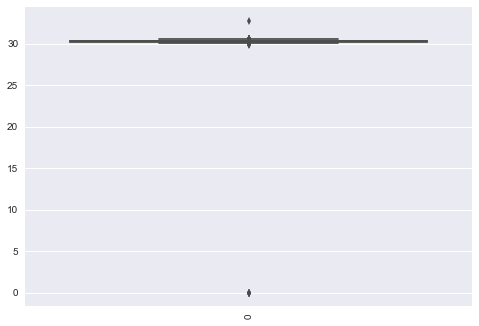

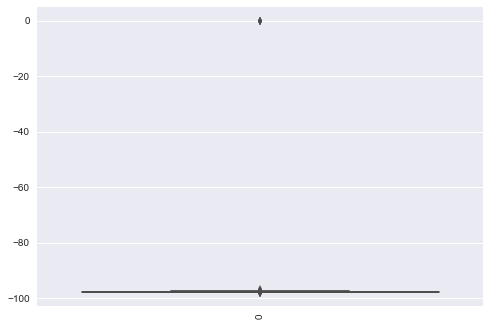

In [16]:
sns.set(style='darkgrid')
lat = sns.boxplot(data=crime_df2['Latitude'])
plt.xticks(rotation=90)
plt.show()

sns.set(style='darkgrid')
g2 = sns.boxplot(data=crime_df2['Longitude'])
plt.xticks(rotation=90)
plt.show()

The outliers in the first boxplot (Latitude) are relatively near centrality and should not impede the plotting of the KDEplot. On the other hand, the outliers in the second boxplot (Longitude) are much further away from centrality, and will cause our plot not to show up. Therefore, we should need remove them.  

Let's check the number of outliers outside the Longitude threshold of -60:

In [17]:
len(crime_df2[crime_df2['Longitude'] >-60])

5

#### Removing the outliers:

In [18]:
crime_df2.drop(crime_df2[crime_df2['Longitude'] >-80].index, inplace=True)

Let's check the boxplot again:

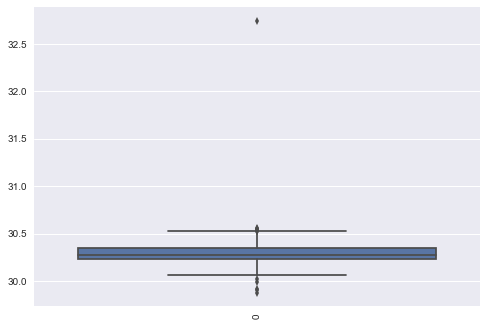

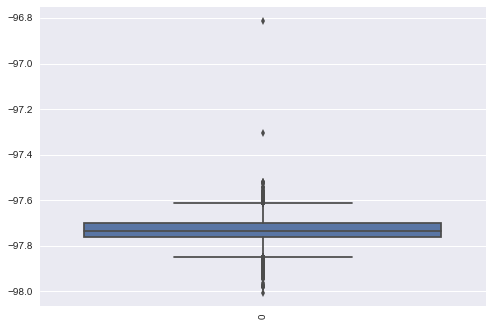

In [19]:
sns.set(style='darkgrid')
g2 = sns.boxplot(data=crime_df2['Latitude'])
plt.xticks(rotation=90)
plt.show()

sns.set(style='darkgrid')
g2 = sns.boxplot(data=crime_df2['Longitude'])
plt.xticks(rotation=90)
plt.show()

The boxplots looks so much better now. Let's check the summary statistics of the two columns:

In [20]:
print('Lat mean: ', crime_df2.Latitude.mean())
print('Lat stdev: ', crime_df2.Latitude.std())
print('Long mean: ', crime_df2.Longitude.mean())
print('Long stdev: ', crime_df2.Longitude.std())

Lat mean:  30.292051149125093
Lat stdev:  0.07775532752800227
Long mean:  -97.73425928871755
Long stdev:  0.047954645059786284


In [21]:
# Peek at the distributions
#sns.distplot(crime_df2.Latitude);
#plt.show()
#sns.distplot(crime_df2.Longitude);
#plt.show()

Let's peek at the cleaned dataframe:

In [22]:
crime_df.head()

,IncidentReportNumber,CrimeType,Date,Time,Address,Longitude,Latitude
0,20175014269,BURGLARY OF VEHICLE,2017-04-06,1900,6934 E BEN WHITE BLVD SVRD WB,-97.703550,30.215663
1,2017970280,CHECK WELFARE,2017-04-07,441,6808 S IH 35 SVRD SB,-97.772963,30.187946
2,20175014277,CRASH/LEAVING THE SCENE,2017-04-06,1330,9414 PARKFIELD DR,-97.706266,30.367904
3,2017961396,ASSAULT WITH INJURY,2017-04-03,2200,5305 KING HENRY DR,-97.660276,30.288873
4,2017970325,BURGLARY NON RESIDENCE,2017-04-06,2030,2005 WHELESS LN,-97.687720,30.313561


In [23]:
crime_df.shape    # checks the size of the cleaned df

(171098, 7)

The dataframe is good to go. Next, we will save it to a file so we can later do data analysis and get insights on crimes in the city of Austin.

# Save cleaned dataframe to a CSV file on disk

In [24]:
# Write the cleaned dataframe to a CSV file
crime_df.to_csv('austin_crime_clean.csv', sep =  ',', index = False)

The dataset is now saved to the same directory as this notebook. 

END